# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
from pandas import json_normalize
import os
from sklearn.preprocessing import StandardScaler

# Reaching the target website and loading the data

In [3]:
#year = input("Year the league began:\n")
year = 2023

In [4]:
url = f"https://understat.com/league/EPL/{year}"

res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

df_game_hist Data

In [5]:
strings = scripts[2].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)

rows = []
for team_id, team_info in data.items():
    for record in team_info['history']:
        record['team_id'] = team_id
        record['team_title'] = team_info['title']
        record['ppda_att'] = record['ppda']['att']
        record['ppda_def'] = record['ppda']['def']
        record['ppda_allowed_att'] = record['ppda_allowed']['att']
        record['ppda_allowed_def'] = record['ppda_allowed']['def']
        del record['ppda'], record['ppda_allowed']
        record['oppda'] = (record['ppda_allowed_att'] / record['ppda_allowed_def'])
        record['ppda'] = (record['ppda_att'] / record['ppda_def'])
        # del record['ppda_allowed_def'], record['ppda_def'], record['ppda_allowed_att'], record['ppda_att']
        rows.append(record)

df_game_hist = pd.DataFrame(rows)

df_games Data

In [6]:
strings = scripts[1].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_games = json_normalize(data)
df_games.dropna(inplace=True)

df_players Data

In [7]:
strings = scripts[3].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_players = json_normalize(data)

Using a "for" loop to reach data for each match individually (this will take time)

df_shots & df_appear Data

In [8]:
df_matches = df_games.dropna()
df_shots = pd.DataFrame()
df_appear = pd.DataFrame()
base_url = 'https://understat.com/match/'

for match in df_matches["id"]:
    
    # Reaching the website
    url = base_url+match

    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find_all('script')

    # df_shots Data
    strings = scripts[1].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    data_h = data["h"]
    data_a = data["a"]

    data_h = json_normalize(data_h)
    data_a = json_normalize(data_a)

    df_temp = pd.concat([data_a, data_h])
    df_temp.drop(["season", "h_goals", "a_goals"], axis = 1, inplace = True)
    df_temp["match_id"] = match
    df_shots = pd.concat([df_shots, df_temp])

    # df_appear Data
    strings= scripts[2].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data_events = json.loads(json_data)

    data_events_h = data_events["h"].values()
    data_events_a = data_events["a"].values()

    data_events_h = pd.DataFrame(data_events_h)
    data_events_a = pd.DataFrame(data_events_a)

    df_temp_events = pd.concat([data_events_a, data_events_h])
    df_temp_events["match_id"] = match
    df_appear = pd.concat([df_appear, df_temp_events])

# exporting as .csv

In [10]:
df_appear.to_csv('df_appear.csv', index=False)
df_shots.to_csv('df_shots.csv', index=False)
df_players.to_csv('df_players.csv', index=False)
df_games.to_csv('df_games.csv', index=False)
df_game_hist.to_csv('df_game_hist.csv', index=False)

#  importing from .csv

In [2]:
df_appear = pd.read_csv('df_appear.csv')
df_shots = pd.read_csv('df_shots.csv')
df_players = pd.read_csv('df_players.csv')
df_games = pd.read_csv('df_games.csv')
df_game_hist = pd.read_csv('df_game_hist.csv')


# Data Manipulation

In [3]:
def convert_to_num(df):
    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
            if (df[column].astype(int) == df[column]).all():
                df[column] = df[column].astype(int)
        except ValueError:
            continue
    return df

In [4]:
df = [df_shots, df_games, df_game_hist, df_appear, df_players]
for i in df:
    i = convert_to_num(i)

# df_team_shots creator function

In [5]:
def team_specific_shots(team):
    df_team_shots = pd.DataFrame()
    df_team_shots = df_shots[((df_shots["h_team"] == team) & (df_shots["h_a"] == "h")) | ((df_shots["a_team"] == team) & (df_shots["h_a"] == "a"))]
    return df_team_shots

# Numeric Variable Distributions (df_game_hist)

In [6]:
df_game_hist.columns

Index(['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts',
       'npxGD', 'team_id', 'team_title', 'ppda_att', 'ppda_def',
       'ppda_allowed_att', 'ppda_allowed_def', 'oppda', 'ppda'],
      dtype='object')

In [7]:
df = df_game_hist[["ppda", "xG", "deep", "xpts", 'oppda']][df_game_hist["team_title"]=="Manchester City"]

In [8]:
for i in df.columns:
    df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())

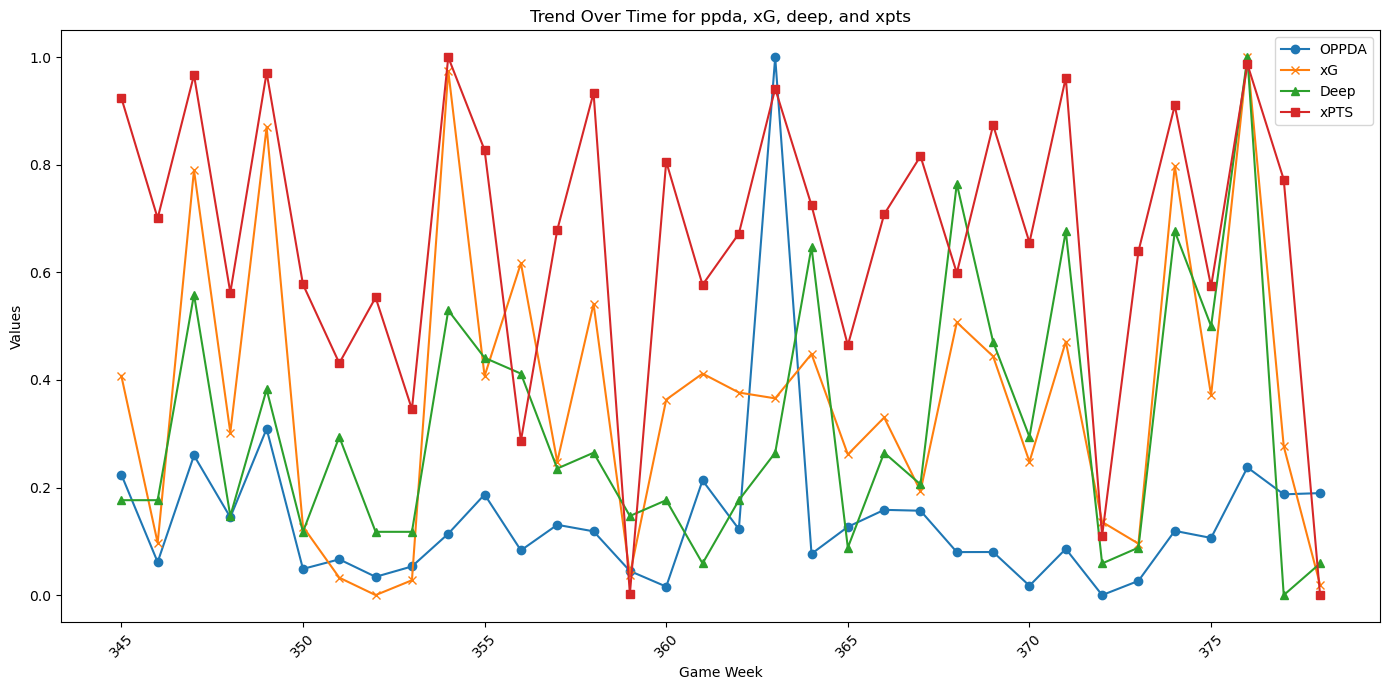

In [9]:
df.sort_index(inplace=True)

# Plot the 'ppda', 'xG', 'deep', and 'xpts' columns
plt.figure(figsize=(14, 7))  # Set the figure size for better readability

plt.plot(df['oppda'], label='OPPDA', marker='o')
plt.plot(df['xG'], label='xG', marker='x')
plt.plot(df['deep'], label='Deep', marker='^')
plt.plot(df['xpts'], label='xPTS', marker='s')

# Add titles and labels
plt.title('Trend Over Time for ppda, xG, deep, and xpts')
plt.xlabel('Game Week')
plt.ylabel('Values')

# Show the legend
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [10]:
print(
np.mean(df_game_hist[["xGA"]][(df_game_hist["team_title"] == "Everton")
& ((df_game_hist['ppda_allowed_def'] - df_game_hist['ppda_def']) < -5)])
,
np.mean(df_game_hist[["xGA"]][(df_game_hist["team_title"] == "Everton")
& ((df_game_hist['ppda_allowed_def'] - df_game_hist['ppda_def']) > 5)])
)

xGA    1.665184
dtype: float64 xGA    1.584079
dtype: float64


C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Sonuç: ppda_att ile ppda_allowed_att değişkenlerinin farkının xg üzerinde doğrudan etkisi var.

In [11]:
print(
np.mean(df_game_hist[['ppda_allowed_def']][df_game_hist["team_title"] == "Manchester City"]),
np.mean(df_game_hist[['ppda_def']][df_game_hist["team_title"] == "Manchester City"]),
"\n",
np.mean(df_game_hist[['ppda_allowed_att']][df_game_hist["team_title"] == "Manchester City"]),
np.mean(df_game_hist[['ppda_att']][df_game_hist["team_title"] == "Manchester City"])
)

ppda_allowed_def    17.5
dtype: float64 ppda_def    19.117647
dtype: float64 
 ppda_allowed_att    350.205882
dtype: float64 ppda_att    210.588235
dtype: float64


C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\G\anaconda3\lib\site-packages\nump

# xG Distribution on 5 minute-range Intervals by Teams (df_shots)

In [12]:
df_team_shots = team_specific_shots("Luton")

In [13]:
def categorize_period(df):
    period = (df['minute'] // 5) * 5
    return f"{period}-{period + 4}"
df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)

C:\Users\G\AppData\Local\Temp\ipykernel_20232\3543908787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)


In [14]:
grouped_xG = df_team_shots.groupby('period')['xG'].agg(["mean", "sum"])
custom_order = ['0-4', '5-9', '10-14', '15-19',
                '20-24','25-29', '30-34', '35-39',
                '40-44','45-49', '50-54', '55-59',
                '60-64','65-69', '70-74', '75-79',
                '80-84','85-89', '90-94', '95-99']
grouped_xG = grouped_xG.reindex(custom_order)

In [15]:
grouped_xG.head()

,mean,sum
period,,
0-4,0.164582,2.139572
5-9,0.099217,1.190603
10-14,0.104692,1.779770
15-19,0.079580,0.954965
20-24,0.163577,3.925844


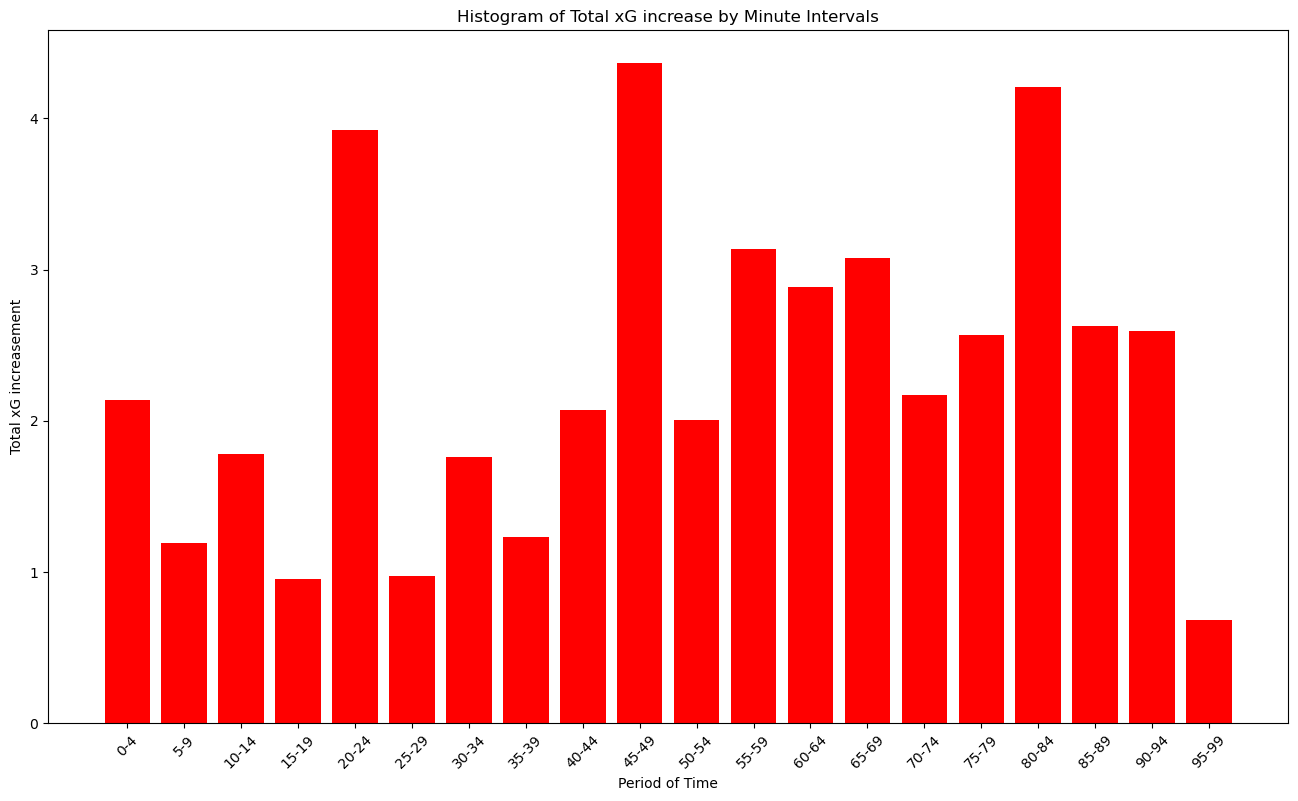

In [16]:
plt.figure(figsize=(16, 9))

plt.bar(grouped_xG.index, grouped_xG["sum"], color='red')

plt.xticks(rotation=45) 
plt.xlabel('Period of Time')
plt.ylabel('Total xG increasement')
plt.title('Histogram of Total xG increase by Minute Intervals')
plt.show()

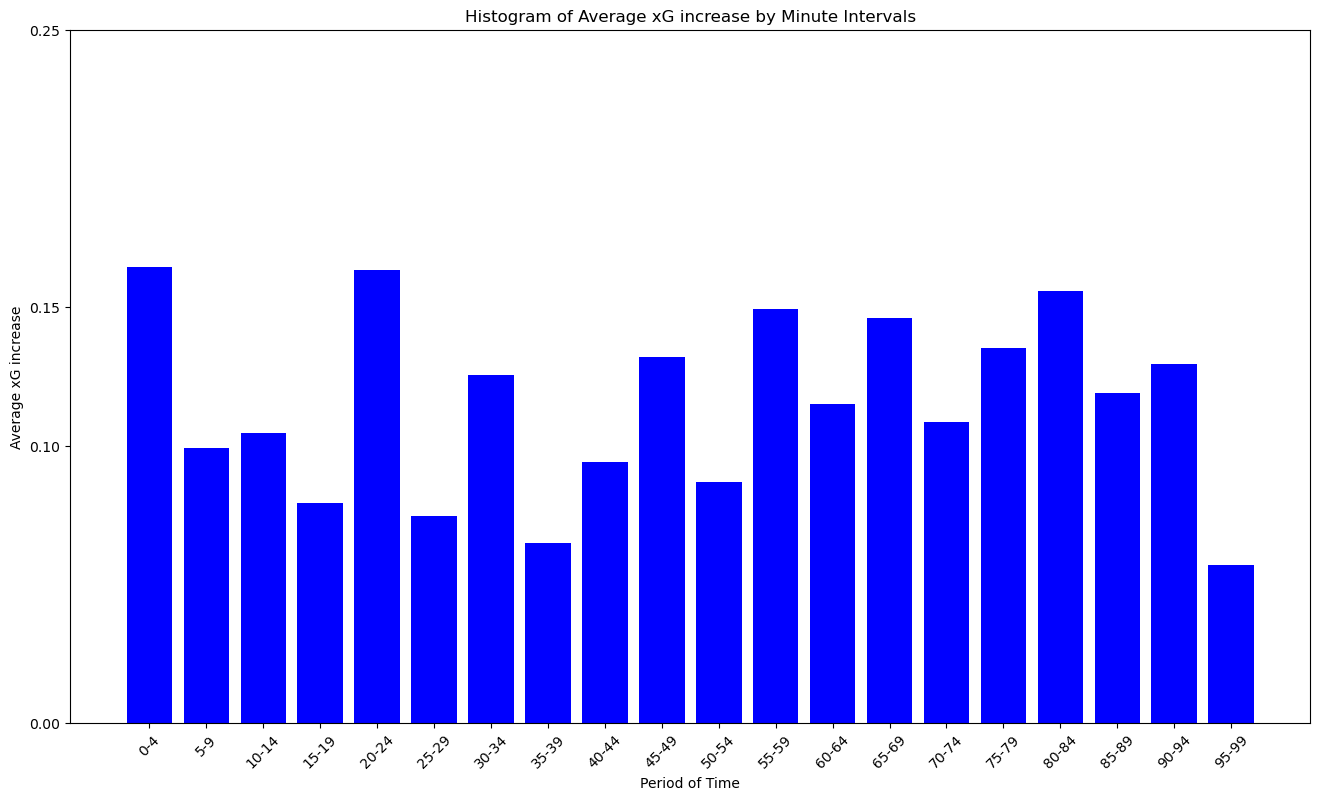

In [17]:
plt.figure(figsize=(16, 9))
plt.bar(grouped_xG.index, grouped_xG["mean"], color='blue')

plt.xticks(rotation=45)
plt.xlabel('Period of Time')
plt.ylabel('Average xG increase')
plt.yticks([0,0.1, 0.15, 0.25])
plt.title('Histogram of Average xG increase by Minute Intervals')
plt.show()

# Correlation Matrix (df_game_hist)

In [18]:
df_game_hist.dropna(inplace=True)
corr_games = df_game_hist[["xG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed"]][df_game_hist["h_a"] == "h"].corr()

Text(0.5, 1.0, 'df_game_hist Korelasyon Matrisi')

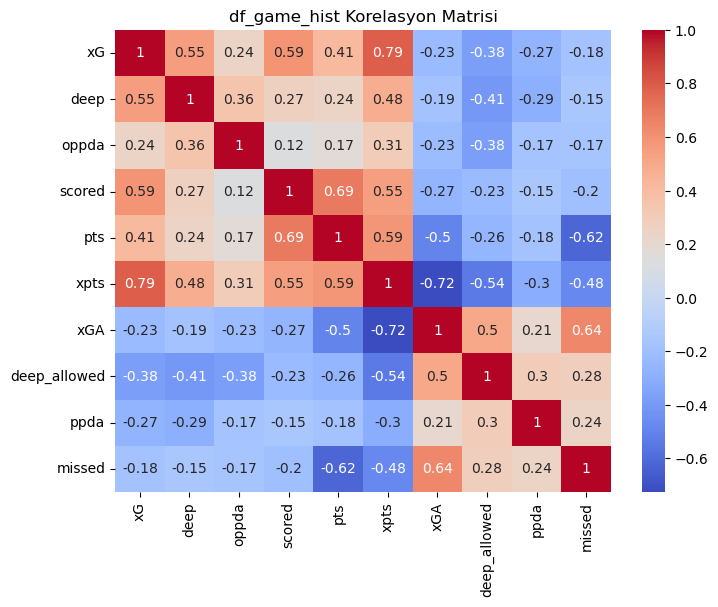

In [19]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_games, annot=True, cmap='coolwarm', cbar=True)
plt.title("df_game_hist Korelasyon Matrisi")

# newline

In [20]:
df_appear_game = pd.merge(df_games, df_appear, left_on='id', right_on= "match_id" , how='inner')

# df_teams Data (generating from df_game_hist)

In [21]:
df_teams = df_game_hist[['team_title', "xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]] 
df_teams = df_teams.groupby('team_title')[["xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]].agg(["mean", "sum"])

# Comparing teams with high "xpts" accuracy with low ones

In [22]:
df_teams["xpts_dif"] = df_teams["xpts", "sum"] - df_teams["pts", "sum"]
df_teams["xG_dif"] = df_teams["xG", "sum"] - df_teams["scored", "sum"]

dif_mean = np.mean(df_teams["xpts_dif"])
dif_std =np.std(df_teams["xpts_dif"])
                
dif_floor = dif_mean - dif_std
dif_ceil = dif_mean + dif_std
 
df_teams_expected = df_teams[(df_teams["xpts_dif"] <  dif_ceil - 1) & (df_teams["xpts_dif"] >  dif_floor + 1)]
df_teams_unexpected = df_teams[(df_teams["xpts_dif"] >  dif_ceil + 1) | (df_teams["xpts_dif"] <  dif_floor - 1)]

In [23]:
df_teams_expected

xG                 npxG                  deep  \
                             mean        sum      mean        sum       mean   
team_title                                                                     
Arsenal                  2.158172  75.536019  1.962444  68.685539  13.542857   
Bournemouth              1.720354  60.212376  1.655111  57.928876   7.971429   
Brighton                 1.590096  54.063252  1.478161  50.257474   9.676471   
Chelsea                  2.087467  68.886424  1.810679  59.752412  10.151515   
Crystal Palace           1.346384  47.123444  1.259394  44.078778   6.057143   
Everton                  1.629588  57.035572  1.586092  55.513228   6.285714   
Fulham                   1.432809  50.148301  1.389313  48.625964   7.971429   
Liverpool                2.398971  83.963972  2.195105  76.828662  13.114286   
Luton                    1.332642  45.309835  1.243093  42.265165   4.705882   
Manchester City          2.260377  76.852803  2.126053  72.285793  13.588235   
Newcastle United         2.113023  71.842782  1.933925  65.753433   8.823529   
Wolverhampton Wanderers  1.378761  46.877890  1.289212  43.833208   6.088235   

                                  oppda                scored      ...  \
                         sum       mean         sum      mean sum  ...   
team_title                                                         ...   
Arsenal                  474  19.769532  691.933617  2.428571  85  ...   
Bournemouth              279   9.249800  323.743001  1.485714  52  ...   
Brighton                 329  24.096661  819.286487  1.529412  52  ...   
Chelsea                  335  15.945929  526.215655  1.909091  63  ...   
Crystal Palace           212   9.094762  318.316678  1.285714  45  ...   
Everton                  220  10.850292  379.760203  1.057143  37  ...   
Fulham                   279  14.509913  507.846968  1.457143  51  ...   
Liverpool                459  19.525904  683.406639  2.200000  77  ...   
Luton                    160   7.988089  271.595029  1.382353  47  ...   
Manchester City          462  24.385851  829.118933  2.411765  82  ...   
Newcastle United         300  12.250972  416.533033  2.176471  74  ...   
Wolverhampton Wanderers  207  10.942063  372.030145  1.352941  46  ...   

                            npxGD                 wins         draws      \
                             mean        sum      mean sum      mean sum   
team_title                                                                 
Arsenal                  1.167777  40.872195  0.714286  25  0.142857   5   
Bournemouth              0.131032   4.586113  0.371429  13  0.257143   9   
Brighton                -0.030842  -1.048628  0.323529  11  0.323529  11   
Chelsea                  0.269985   8.909520  0.393939  13  0.272727   9   
Crystal Palace          -0.272349  -9.532222  0.285714  10  0.285714  10   
Everton                  0.170657   5.973011  0.342857  12  0.228571   8   
Fulham                  -0.219491  -7.682177  0.342857  12  0.200000   7   
Liverpool                0.994598  34.810921  0.628571  22  0.257143   9   
Luton                   -1.163331 -39.553253  0.176471   6  0.205882   7   
Manchester City          1.172541  39.866393  0.705882  24  0.205882   7   
Newcastle United         0.400890  13.630260  0.470588  16  0.147059   5   
Wolverhampton Wanderers -0.414763 -14.101956  0.352941  12  0.205882   7   

                            loses     xpts_dif     xG_dif  
                             mean sum                      
team_title                                                 
Arsenal                  0.142857   5  -6.2414  -9.463981  
Bournemouth              0.371429  13   2.9882   8.212376  
Brighton                 0.352941  12   3.1661   2.063252  
Chelsea                  0.333333  11   7.3267   5.886424  
Crystal Palace           0.428571  15   2.9506   2.123444  
Everton                  0.428571  15   4.8936  20.035572  
Fulham                   0.457143  16 

# df_team_games

In [24]:
team = "Manchester City"
df_team_games = df_games[(df_games["datetime"] == min(df_games["datetime"])) &
(df_games["a.title"] == team) | (df_games["h.title"] == team)]
df_team_games.head()

,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l
0,22275,1,2023-08-11 19:00:00,92,Burnley,BUR,88,Manchester City,MCI,0,3,0.311032,2.400740,0.0177,0.0854,0.8969
15,22291,1,2023-08-19 19:00:00,88,Manchester City,MCI,86,Newcastle United,NEW,1,0,1.225280,0.257154,0.6449,0.2857,0.0694
31,21927,1,2023-09-02 14:00:00,88,Manchester City,MCI,228,Fulham,FLH,5,1,2.001520,1.464270,0.5230,0.3082,0.1688
50,21946,1,2023-09-23 14:00:00,88,Manchester City,MCI,249,Nottingham Forest,NOT,2,0,1.339840,0.729109,0.5453,0.2792,0.1755
83,21980,1,2023-10-21 14:00:00,88,Manchester City,MCI,220,Brighton,BRI,2,1,0.962509,0.963733,0.3367,0.3286,0.3347


In [25]:
def team_games(df):
    period = (df[['h.title']]['h.title'])
    return f"{period}-{period + 4}"
df_team_games['period'] = df_team_shots.apply(categorize_period, axis=1)

C:\Users\G\AppData\Local\Temp\ipykernel_20232\4054156056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_games['period'] = df_team_shots.apply(categorize_period, axis=1)


# Player according to the position species

In [26]:
df_manc_players = df_players[df_players["team_title"]=="Manchester City"]
df_manc_players[(df_manc_players["id"]== 8260) | (df_manc_players["id"]== 10846)]

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,8260,Erling Haaland,27,2226,21,25.778036,5,4.668719,105,28,1,0,F S,Manchester City,17,21.972193,26.716977,2.660533
26,10846,Julián Álvarez,33,2675,9,13.236120,8,5.823112,96,66,2,0,F M S,Manchester City,8,12.474951,26.154436,12.457787


In [27]:
df_shots_alvares = df_shots[df_shots["player_id"] == 10846]
df_shots_haaland = df_shots[df_shots["player_id"] == 8260]

In [28]:
df_haaland_hist = df_shots_haaland.groupby(["situation", "shotType", "lastAction", "result"])["xG"].agg(["sum", "count"])
df_haaland_hist.reset_index(inplace = True)

df_haaland_hist['result'] = df_haaland_hist['result'].apply(lambda x: 1 if x == 'Goal' else 0)

# Group by 'shotType', 'lastAction', and 'result' and then sum up
df_haaland_hist = df_haaland_hist.groupby(["situation", 'lastAction', 'shotType', 'result']).agg({'sum': 'sum', 'count': 'sum'}).reset_index()

df_haaland_hist

# ["miss_total"] = df_haaland_hist["shotType"]["lastAction"]["BlockedShot", "MissedShots", "SavedShot"].sum()

,situation,lastAction,shotType,result,sum,count
0,DirectFreekick,Standard,LeftFoot,0,0.052741,1
1,FromCorner,Aerial,Head,0,0.143752,3
2,FromCorner,Chipped,LeftFoot,0,0.037390,1
3,FromCorner,Cross,LeftFoot,0,0.048156,1
4,FromCorner,HeadPass,LeftFoot,0,0.080246,1
5,FromCorner,HeadPass,LeftFoot,1,0.505846,1
6,FromCorner,None,Head,0,0.082122,1
7,FromCorner,None,LeftFoot,0,0.102915,1
8,FromCorner,Pass,LeftFoot,0,0.637852,1
9,FromCorner,Rebound,RightFoot,1,0.073492,1


# Dakikaya göre xG

In [29]:
df_appear.reset_index(inplace = True)
df_appear.set_index("id", inplace = True)

In [30]:
#df_xgtime = df_appear[df_appear["player_id"] == plid]
df_xgtime = df_appear

In [31]:
df_xgtime["entered"] = df_xgtime["roster_out"].apply(lambda x: 0 if x == 0 else (90 - int(df_xgtime[df_xgtime["roster_out"] == x]["time"])))

In [32]:
df_xgtime = df_xgtime[["entered", "player_id", "match_id", "player"]]

In [33]:
xG_cummulative = float(0)
xG_dict_cumm = {}

df_min_xg = pd.merge(df_xgtime, df_shots, on=['player_id', 'match_id'], how='inner')
df_min_xg["time"] = df_min_xg["minute"] - df_min_xg["entered"]

for i in range(100):
    xG_cummulative = xG_cummulative + sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_dict_cumm[i] = xG_cummulative

<Axes: >

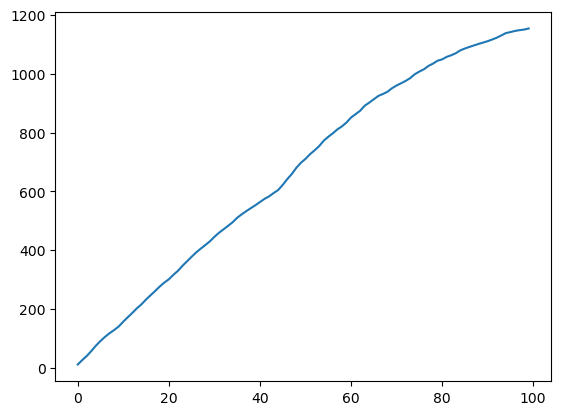

In [34]:
sns.lineplot(xG_dict_cumm)

In [35]:
xG_norm = float(0)
xG_dict = {}

for i in range(100):
    xG_norm = np.sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_dict[i] = xG_norm


<Axes: >

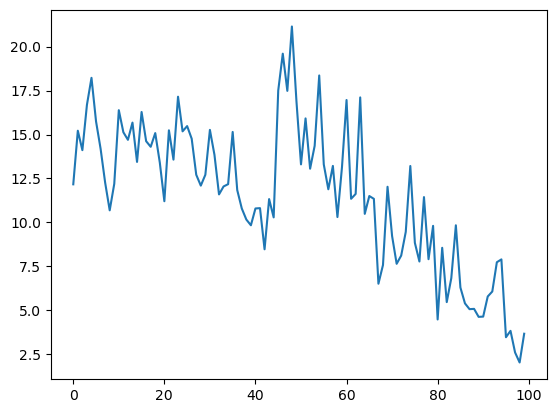

In [36]:
sns.lineplot(xG_dict)

In [38]:
df_player_xg_pos = pd.merge(df_min_xg, df_players, left_on = "player_id", right_on = "id", how = "inner")[["time_x", "player_x", "player_id", "match_id", "xG_x", "id_x", "position"]]

df_player_xg_pos['main_pos'] = df_player_xg_pos['position'].apply(lambda x: x[0])

In [39]:
df_xgtime_player = df_xgtime[df_xgtime["player"] == "Gabriel"]
df_player_min_xg = pd.merge(df_xgtime_player, df_shots, on=['player_id', 'match_id'], how='inner')
df_player_min_xg["time"] = df_player_min_xg["minute"] - df_player_min_xg["entered"]

In [40]:
xG_cummulative_player = float(0)
xG_dict_cumm_player = {}
for i in range(100):
    xG_cummulative_player = xG_cummulative_player + sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_cumm_player[i] = xG_cummulative_player

In [41]:
xG_player = float(0)
xG_dict_player = {}
for i in range(100):
    xG_player = sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_player[i] = xG_player

Her bir mevki için toplam oyuncu sayısını oranlamak için aşağıdaki ölçüler kullanılır.

In [42]:
df_player_xg_pos.groupby("main_pos").size()

main_pos
D    2270
F    4605
G       9
M    2568
S      69
dtype: int64

In [43]:
2270 + 4605 + 2568

9443

In [44]:
avg_player_per_match = (np.mean(df_player_xg_pos[df_player_xg_pos["main_pos"] != "G"].groupby("match_id")["player_id"].agg("size")))/2

<Axes: >

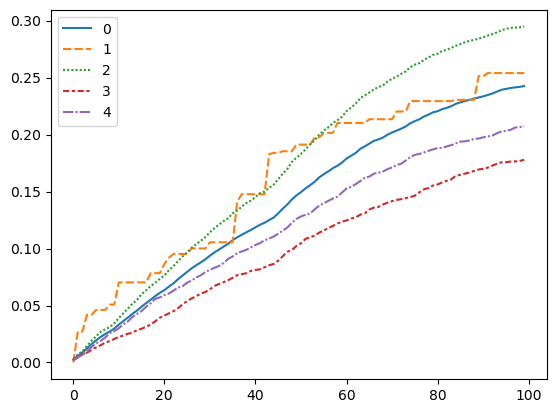

In [45]:
df_min_xg_fw = df_player_xg_pos[df_player_xg_pos["main_pos"] == "F"]
df_min_xg_def =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "M"]
df_min_xg_mid =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "D"]

general_xg_scaled = [x / (df_min_xg["match_id"].nunique() 
                          * avg_player_per_match
                         ) for x in list(xG_dict_cumm.values())]


xG_cummulative_fw = 0
xG_dict_cumm_fw = {}
for i in range(100):
    xG_cummulative_fw = xG_cummulative_fw + sum(df_min_xg_fw[df_min_xg_fw["time_x"] == i]["xG_x"])
    xG_dict_cumm_fw[i] = xG_cummulative_fw
fw_xg_scaled = [(x / (df_min_xg_fw["match_id"].nunique()
                       * avg_player_per_match * (4605/9443)
                     ))  for x in list(xG_dict_cumm_fw.values())]

xG_cummulative_def = 0
xG_dict_cumm_def = {}
for i in range(100):
    xG_cummulative_def = xG_cummulative_def + sum(df_min_xg_def[df_min_xg_def["time_x"] == i]["xG_x"])
    xG_dict_cumm_def[i] = xG_cummulative_def
def_xg_scaled = [(x / (df_min_xg_def["match_id"].nunique() 
                        * avg_player_per_match * (2270/9443) 
                      )) for x in list(xG_dict_cumm_def.values())]

xG_cummulative_mid = 0
xG_dict_cumm_mid = {}
for i in range(100):
    xG_cummulative_mid = xG_cummulative_mid + sum(df_min_xg_mid[df_min_xg_mid["time_x"] == i]["xG_x"])
    xG_dict_cumm_mid[i] = xG_cummulative_mid
mid_xg_scaled = [(x / (df_min_xg_mid["match_id"].nunique()
                        * avg_player_per_match * (2568/9443)
                      )) for x in list(xG_dict_cumm_mid.values())]
    

player_xg_scaled =  [x / df_player_min_xg["match_id"].nunique() for x in list(xG_dict_cumm_player.values())]

sns.lineplot([general_xg_scaled, player_xg_scaled, fw_xg_scaled, mid_xg_scaled, def_xg_scaled])

# newline

Anlık olarak oynayan oyuncuları filtrele

Bu oyunculara ve rakip metriklerine göre kalan zaman xG tahmini

Yedekteki oyuncu xG tahmini